## Problem 1: SimpleRNN forward propagation.

In [23]:
import numpy as np
class SimpleRNN:
    def __init__(self, w_x, w_h, b):
        """
        w_x: (n_nodes, n_features)
        (n_nodes, n_nodes) w_h
        (n_nodes, b)
        """
        self.w_x = w_x
        self.w_h = w_h
        self.b = b

    def forward(self, x, h0=None):
        """
        x: (batch_size, n_features, n_sequences)
        yields all hidden states (batch_size, n_sequences, n_nodes) as well as the final hidden state h_T.
        """
        batch_size = x.shape[0]
        n_sequences = x.shape[1]
        n_nodes = self.w_x.shape[1]

        if h0 is None:
            h = np.zeros((batch_size, n_nodes))
        else:
            h = h0

        hs = []
        for t in range(n_sequences):
            x_t = x[:, t, :]                          # (n features, batch size)
            a_t = x_t.dot(self.w_x) + h.dot(self.w_h) + self.b  # (n nodes, batch size)
            h = np.tanh(a_t)                         #initiation
            hs.append(h.copy())

        hs = np.stack(hs, axis=1)  # (n_sequences, n_nodes, batch_size)
        return h, hs


### Test with a small example from the Assignment

In [24]:
# Provided illustration (from the task)
x = np.array([[[1, 2], [2, 3], [3, 4]]]) / 100.0  # (n_sequences, n_features, batch_size)
w_x = np.array([[1, 3, 5, 7], [3, 5, 7, 8]]) / 100.0  # (n_nodes, n_features)
w_h = np.array([[1, 3, 5, 7],
                [2, 4, 6, 8],
                [3, 5, 7, 8],
                [4, 6, 8, 10]]) / 100.0  # (number of nodes)
b = np.array([1, 1, 1, 1])  # (n_nodes)

rnn = SimpleRNN(w_x=w_x, w_h=w_h, b=b)
h_final, hs = rnn.forward(x)

print("Final hidden state (h_T):")
print(h_final)

# Expected from the task:
expected = np.array([[0.79494228, 0.81839002, 0.83939649, 0.85584174]])
print("\nMatches expected:", np.allclose(h_final, expected, atol=1e-8))


Final hidden state (h_T):
[[0.79494228 0.81839002 0.83939649 0.85584174]]

Matches expected: True


## Problem 2: Backpropagation Through Time - Gradient Computation.

In [25]:
import numpy as np

class SimpleRNN_BPTT:
    def __init__(self, w_x, w_h, b):
        self.w_x = w_x
        self.w_h = w_h
        self.b = b

    def forward(self, x):
        batch_size, n_seq, _ = x.shape
        n_nodes = self.w_x.shape[1]
        h = np.zeros((batch_size, n_nodes))
        hs = []
        for t in range(n_seq):
            a_t = x[:, t, :] @ self.w_x + h @ self.w_h + self.b
            h = np.tanh(a_t)
            hs.append(h)
        return np.stack(hs, axis=1)

    def backward(self, x, hs, dh_last):
        batch_size, n_seq, _ = x.shape
        n_nodes = self.w_x.shape[1]

        dh_next = dh_last
        dw_x = np.zeros_like(self.w_x)
        dw_h = np.zeros_like(self.w_h)
        db = np.zeros_like(self.b)
        dh_prev = np.zeros((batch_size, n_nodes))

        for t in reversed(range(n_seq)):
            h_t = hs[:, t, :]
            h_prev = hs[:, t - 1, :] if t > 0 else np.zeros_like(h_t)
            da = (1 - h_t ** 2) * (dh_next + dh_prev)
            dw_x += x[:, t, :].T @ da
            dw_h += h_prev.T @ da
            db += np.sum(da, axis=0)
            dh_prev = da @ self.w_h.T

        grads = {'dw_x': dw_x / batch_size,
                 'dw_h': dw_h / batch_size,
                 'db': db / batch_size}
        return grads


### Small test.

In [26]:
x = np.random.rand(2, 3, 2)
w_x = np.random.rand(2, 4)
w_h = np.random.rand(4, 4)
b = np.zeros(4)
dh_last = np.ones((2, 4))

rnn = SimpleRNN_BPTT(w_x, w_h, b)
hs = rnn.forward(x)
grads = rnn.backward(x, hs, dh_last)

for k, v in grads.items():
    print(f"{k}:\n", v, "\n")

dw_x:
 [[2.12808326 2.5844729  0.91959707 2.49142378]
 [1.5045896  1.67736503 0.6540562  1.61229585]] 

dw_h:
 [[0.27754065 0.4729571  0.12626167 0.47401918]
 [0.28303007 0.44231425 0.1231844  0.44949511]
 [0.76993178 1.14148479 0.33283018 1.16647904]
 [0.16902808 0.27867746 0.07620611 0.28039718]] 

db:
 [5.65951349 6.40855718 2.51762125 5.97143194] 



## Problem 3: Training the RNN [Forward/Backward/Weight updates]

In [27]:
import numpy as np

class ScratchSimpleRNNClassifier:
    def __init__(self, n_features, n_nodes, n_output, learning_rate=0.01):
        self.n_features = n_features
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.lr = learning_rate

        # Set up the weights.
        self.Wx = np.random.randn(n_features, n_nodes) * 0.1
        self.Wh = np.random.randn(n_nodes, n_nodes) * 0.1
        self.Bh = np.zeros(n_nodes)
        self.Wy = np.random.randn(n_nodes, n_output) * 0.1
        self.By = np.zeros(n_output)

    def forward(self, x):
        batch_size, n_seq, _ = x.shape
        h = np.zeros((batch_size, self.n_nodes))
        self.hs, self.xs = [], []

        for t in range(n_seq):
            xt = x[:, t, :]
            a = xt @ self.Wx + h @ self.Wh + self.Bh
            h = np.tanh(a)
            self.hs.append(h)
            self.xs.append(xt)
        self.h_last = h
        y_pred = h @ self.Wy + self.By
        return y_pred

    def backward(self, x, y, y_pred):
        batch_size, n_seq, _ = x.shape
        dy = (y_pred - y) / batch_size
        dWy = self.hs[-1].T @ dy
        dBy = np.sum(dy, axis=0)

        dh_next = dy @ self.Wy.T
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        dBh = np.zeros_like(self.Bh)

        for t in reversed(range(n_seq)):
            ht = self.hs[t]
            d_tanh = (1 - ht ** 2) * dh_next
            dWx += self.xs[t].T @ d_tanh
            if t != 0:
                dWh += self.hs[t-1].T @ d_tanh
            dBh += np.sum(d_tanh, axis=0)
            dh_next = d_tanh @ self.Wh.T

        # Modify weights
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh
        self.Bh -= self.lr * dBh
        self.Wy -= self.lr * dWy
        self.By -= self.lr * dBy

    def train(self, x, y, epochs=50):
        loss_history = []
        for epoch in range(epochs):
            y_pred = self.forward(x)
            loss = np.mean((y_pred - y) ** 2)
            loss_history.append(loss)
            self.backward(x, y, y_pred)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
        return loss_history

### Test Cell.

In [28]:
# Fake data
np.random.seed(0)
x = np.random.rand(2, 3, 2)   # (batch_size, n_features, seq_len)
y = np.array([[0.5], [0.8]])

model = ScratchSimpleRNNClassifier(n_features=2, n_nodes=4, n_output=1, learning_rate=0.1)
loss_history = model.train(x, y, epochs=50)

Epoch 10, Loss: 0.068712
Epoch 20, Loss: 0.024700
Epoch 30, Loss: 0.021294
Epoch 40, Loss: 0.020934
Epoch 50, Loss: 0.020771


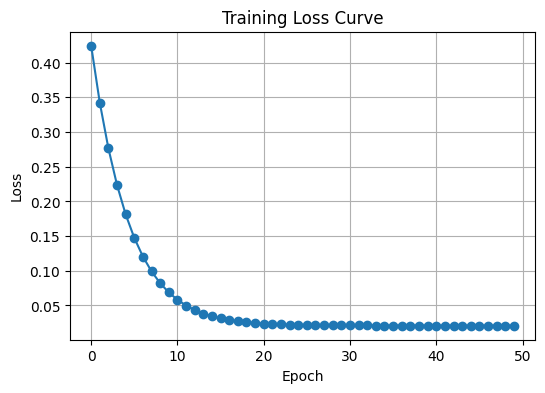

Plot saved to: plots\training_loss_curve.png


In [29]:
# Plot the training loss curve and save it to /plots for optional viewing.
import os
import matplotlib.pyplot as plt

# If the /plots folder isn't already there, create it.
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(6, 4))
plt.plot(loss_history, marker='o', linewidth=1.5)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Keep the plot
plot_path = os.path.join("plots", "training_loss_curve.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {plot_path}")